<a href="https://colab.research.google.com/github/jcmachicao/modpred_2/blob/main/modpred__02_5_redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #**2.5**
#### Cuaderno 2, Ejercicio 5
#### **Curso Modelamiento Predictivo**
---
# **Introducción a Redes Neuronales**
* Autor: José Carlos Machicao
* Licencia: [GestioDinámica](http://www.gestiodinamica.com) 2020

[Tensorflow Playground](https://playground.tensorflow.org)

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt 

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
ruta = 'drive/My Drive/2020 data/'

In [4]:
dataset = pd.read_excel(ruta + 'ActosViolentos.xlsx')
dataset.head()

,Edad,Hora,Sexo,Area,Ingreso,Violento
0,Niño,17,M,A1,2,No Violento
1,Niño,3,F,A3,4,No Violento
2,Niño,19,F,A1,3,No Violento
3,Niño,23,M,A1,2,No Violento
4,Niño,7,F,A2,5,Violento


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Edad      900 non-null    object
 1   Hora      900 non-null    int64 
 2   Sexo      900 non-null    object
 3   Area      900 non-null    object
 4   Ingreso   900 non-null    int64 
 5   Violento  900 non-null    object
dtypes: int64(2), object(4)
memory usage: 42.3+ KB


In [9]:
cat_var = ['Edad', 'Sexo', 'Area']
cat_num = ['Hora', 'Ingreso']

In [7]:
dataset[cat_var].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Edad    900 non-null    object
 1   Sexo    900 non-null    object
 2   Area    900 non-null    object
dtypes: object(3)
memory usage: 21.2+ KB


In [10]:
data_cat = pd.get_dummies(dataset[cat_var], drop_first=True)
data_num = dataset[cat_num]
data = pd.concat([data_cat, data_num], axis=1)
scl = MinMaxScaler()
scl.fit(data)
data = scl.transform(data)
data.shape, type(data)

((900, 9), numpy.ndarray)

In [11]:
labels = np.array(pd.factorize(dataset.Violento)[0])
labels.shape, type(labels)

((900,), numpy.ndarray)

In [12]:
X_np = data.astype(np.float32)
y_np = labels.reshape(-1, 1).astype(np.float32)
#y_np = labels.reshape(-1, 1)

In [13]:
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np.reshape(-1, 1))

In [14]:
X.shape, y.shape

(torch.Size([900, 9]), torch.Size([900, 1]))

In [15]:
torch.cuda.device_count(), torch.cuda.get_device_name(0)

(1, 'Tesla T4')

In [16]:
model = nn.Sequential(
  nn.Linear(X.shape[1], X.shape[0]),
  nn.ReLU(),
  nn.Linear(X.shape[0], 900),
  nn.ReLU(),
  nn.Linear(900, 500),
  nn.ReLU(),
  nn.Linear(500, 100),
  nn.ReLU(),
  nn.Linear(100, 1)
)

In [17]:
model.cuda()
X_g = X.cuda()
y_g = y.cuda()

In [18]:
optimizador = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
#criterio = torch.nn.CrossEntropyLoss().cuda()
criterio = torch.nn.MSELoss()

In [24]:
errores = []

In [25]:
preds = []
for epo in range(50000):
  optimizador.zero_grad()
  y_pred = model(X_g)
  loss = criterio(y_pred, y_g)
  loss.backward()
  optimizador.step()
  if epo % 10000 == 0:
    print(epo, loss.item())
    errores.append([epo, loss.item()])
    pred = y_pred.cpu().detach().numpy()
    preds.append(pred)

0 0.02054191194474697
10000 0.02193559892475605
20000 0.017569780349731445
30000 0.017583943903446198
40000 0.02314557507634163


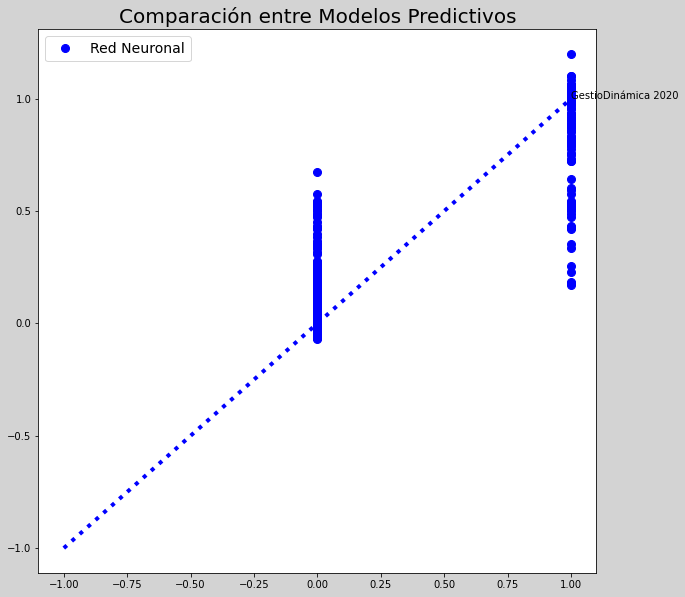

In [22]:
#@title Gráfica
plt.figure(figsize=(10,10), facecolor='lightgray')

plt.plot(y_np, pred, 'bo', ms=8, label='Red Neuronal')
plt.plot([-1,1], [-1, 1], 'b:', lw=4)

plt.title('Comparación entre Modelos Predictivos', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.text(1,1, 'GestioDinámica 2020')
plt.show()

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
mlm = lr.fit(X_np, y_np)
nb = GaussianNB()
mnb = nb.fit(X_np, y_np)
pred_lm = mlm.predict(X_np)
pred_nb = mnb.predict(X_np)
len(X_np), len(pred_lm)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(900, 900)

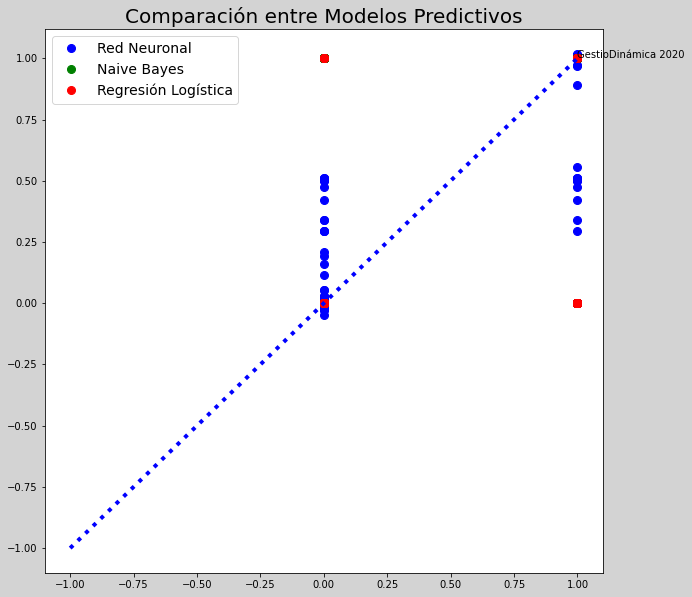

In [37]:
#@title Gráfica
plt.figure(figsize=(10,10), facecolor='lightgray')

plt.plot(y_np, pred, 'bo', ms=8, label='Red Neuronal')
plt.plot(y_np, pred_nb, 'go', ms=8, label='Naive Bayes')
plt.plot(y_np, pred_lm, 'ro', ms=8, label='Regresión Logística')
plt.plot([-1,1], [-1, 1], 'b:', lw=4)

plt.title('Comparación entre Modelos Predictivos', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.text(1,1, 'GestioDinámica 2020')
plt.show()

In [41]:
data_test = X[0:10].cuda()

In [42]:
model(data_test)

tensor([[0.0118],
        [0.0022],
        [0.0109],
        [0.0042],
        [1.0242],
        [0.0139],
        [1.0227],
        [0.0019],
        [1.0265],
        [0.0090]], device='cuda:0', grad_fn=<AddmmBackward>)

In [7]:
#print(pred[0:10])
indices = [i for i in range(len(pred)) if pred[i] > 0.75]
len(indices)

NameError: ignored

In [6]:
data_10 = dataset.iloc[indices,:]
data_10.head()

NameError: ignored

In [55]:
pd.plotting.parallel_coordinates(data_10)

TypeError: ignored

### Referencias
https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
